# DMML - Assignment 3: Semi-Supervised Learning
- Aman Kumar [MDS202104]
- Jayasooryan C S [MDS202119]

## Objective:
- Use clustering for semi-supervised learning of the MNIST Fasion dataset
  - Identify a small subset of labelled images using K Means clustering to seed the classification process
  - Train the model using labeled centeroid of the clusters
  - Train the  model by propagating the label of the centroid to its nearest neighbours

## Imports 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, losses, metrics, callbacks, datasets
from tensorflow.keras.utils import plot_model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from joblib import dump, load
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
seed=42
tf.random.set_seed(seed)


In [ ]:
! pip install memory-profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=f4376cbcde472b4c795f7331c2f9868a7d026c0b361e08dc04e05a86026ffb5b
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


In [ ]:
%load_ext memory_profiler

## Loading Data

In [ ]:
(X_train,y_train),(X_test,y_test)=datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [ ]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

There are 60000 images in the training set and 10000 images in the test set. Each image is represented by a  28×28  pixel matrix. Each pixel intensity is represented as a byte (0 to 255).

## Plotting an Image:

Let's see an image using Matplotlib's imshow() function, with a 'binary' color map

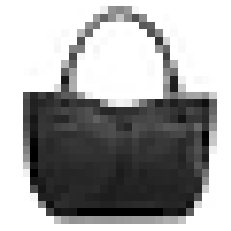

In [ ]:
plt.imshow(X_train[100], cmap="binary")
plt.axis('off')
plt.show()

In [ ]:
class_names[y_train[100]]

'Bag'

So, 100th indexed image in training set is "Bag"


## Data Preprocessing:

Pixel intensity of the images are scaled down to 0-1 range by dividing with 255.

In [ ]:
# Normalizing 
X_train, X_test= X_train/255.0, X_test/255.0

In [ ]:
X_train[1][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00392157, 0.        , 0.        , 0.        , 0.        ,
       0.16078431, 0.7372549 , 0.40392157, 0.21176471, 0.18823529,
       0.16862745, 0.34117647, 0.65882353, 0.52156863, 0.0627451 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

The image matrix is flattened to a 1D array for implementing Logistic Regression.

In [ ]:
# Flattening data for Logistic Regression
X_train_flatten= X_train.reshape(X_train.shape[0],-1)
y_train_flatten= y_train.reshape(y_train.shape[0],-1)
X_test_flatten= X_test.reshape(X_test.shape[0],-1)
y_test_flatten= y_test.reshape(y_test.shape[0],-1)

## Supervised Learning

In [ ]:
from sklearn.linear_model import LogisticRegression

Training a Logistic Regression Model using the entire labelled training data. Accuracy obtained here would be the threshold of achievable accuracy using this model with the given hyperparameters.

In [ ]:
%%time
%%memit

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_flatten, y_train_flatten)


peak memory: 1056.75 MiB, increment: 1.17 MiB
CPU times: user 11min 41s, sys: 53.3 s, total: 12min 34s
Wall time: 6min 41s


In [ ]:
log_reg.score(X_test_flatten, y_test_flatten)

0.841

Now we train the model using random 300 labeled data and later compare the change in accuracy on Semi-Supervised Learning with Clustering approach.

In [ ]:
import random
val = 0.5
arr = [random.random() for i in range(X_train.shape[0])]
val_arr = [random.random()>val for i in range(6000)]


X_train_random = []
y_train_random = []

for i in range(X_train.shape[0]):
  if val_arr:
    X_train_random.append(X_train_flatten[i])
    y_train_random.append(y_train_flatten[i])

In [ ]:
%%time
%%memit

log_reg_6 = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg_6.fit(X_train_random[:300], y_train_random[:300])
log_reg_6.score(X_test_flatten, y_test_flatten)

peak memory: 1700.21 MiB, increment: 1.85 MiB
CPU times: user 1.01 s, sys: 611 ms, total: 1.62 s
Wall time: 2.23 s


In [ ]:
log_reg_6.score(X_test_flatten, y_test_flatten)

0.7776

Here the accuracy decreased from 84% to 77%, which is an expected trend.

## Semi-Supervised Learning with Clustering

Here initially, we cluster the data set using K Means Clustering, in this problem K= 300. Then we find the centroid of each cluster and label the centroids manually and train the model using these 300 labelled data. Later we would progate the label of the cetroid to a nearest fraction of points in each cluster and train the model again and compare its performances

In [ ]:
%%time
%%memit

k = 300

kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train_flatten)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

peak memory: 1844.88 MiB, increment: 0.12 MiB
CPU times: user 19min 33s, sys: 1min 15s, total: 20min 49s
Wall time: 11min 9s


In [ ]:
X_representative_digits[0].shape

X_representative_digits = X_representative_digits.reshape(X_representative_digits.shape[0], -1)

In [ ]:
y_train[representative_digit_idx]

array([5, 3, 2, 4, 8, 1, 9, 0, 6, 4, 0, 8, 6, 8, 1, 8, 4, 1, 7, 8, 2, 9,
       8, 6, 7, 3, 2, 2, 9, 4, 2, 0, 8, 9, 9, 7, 6, 0, 4, 9, 7, 2, 0, 3,
       4, 0, 3, 6, 2, 8, 9, 4, 1, 1, 5, 9, 1, 1, 7, 6, 4, 5, 3, 1, 9, 3,
       1, 3, 0, 2, 8, 1, 2, 8, 3, 2, 0, 4, 9, 0, 9, 0, 1, 7, 4, 9, 9, 5,
       5, 2, 0, 9, 4, 0, 0, 2, 3, 6, 4, 5, 2, 5, 6, 4, 0, 7, 8, 6, 5, 9,
       7, 4, 7, 5, 8, 7, 4, 1, 6, 0, 6, 6, 3, 8, 2, 1, 4, 9, 7, 2, 9, 7,
       8, 7, 3, 0, 5, 8, 8, 7, 8, 9, 4, 2, 4, 4, 9, 6, 2, 8, 6, 7, 4, 6,
       1, 8, 3, 9, 3, 7, 1, 2, 4, 9, 9, 9, 2, 0, 8, 3, 3, 8, 5, 1, 8, 6,
       9, 1, 9, 9, 8, 4, 9, 6, 3, 0, 9, 0, 2, 8, 9, 2, 0, 5, 2, 5, 4, 9,
       2, 3, 4, 1, 2, 1, 8, 4, 9, 4, 6, 1, 6, 7, 4, 5, 8, 9, 9, 0, 2, 4,
       9, 6, 5, 9, 3, 4, 3, 8, 4, 2, 1, 4, 5, 9, 2, 0, 3, 6, 5, 6, 3, 0,
       9, 9, 6, 1, 0, 9, 0, 6, 8, 6, 8, 3, 0, 4, 1, 7, 0, 2, 4, 2, 6, 8,
       6, 8, 3, 9, 2, 6, 2, 3, 0, 2, 2, 4, 5, 5, 0, 7, 3, 0, 8, 2, 1, 9,
       2, 4, 7, 9, 7, 3, 4, 9, 0, 3, 8, 9, 8, 5], d

Now we have a dataset with 300 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [ ]:
%%time
%%memit

log_reg_2 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg_2.fit(X_representative_digits, y_representative_digits)

peak memory: 2002.97 MiB, increment: 0.00 MiB
CPU times: user 857 ms, sys: 362 ms, total: 1.22 s
Wall time: 872 ms


In [ ]:
log_reg_2.score(X_test_flatten, y_test_flatten)

0.7622

## Comments:
 - We expected the accuracy of the model to increase when the random images are changes with cetroids. But in the experiment the accuracy decreased.


## Variations with different K values

In [ ]:
%%time
%%memit

k = [50, 100,200, 300]

for k_val in k:
  kmeans = KMeans(n_clusters=k_val, random_state=42)
  X_digits_dist = kmeans.fit_transform(X_train_flatten)
  representative_digit_idx = np.argmin(X_digits_dist, axis=0)
  X_representative_digits = X_train[representative_digit_idx]
  X_representative_digits = X_representative_digits.reshape(X_representative_digits.shape[0], -1)
  y_representative_digits = y_train[representative_digit_idx]
  log_reg_2 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
  log_reg_2.fit(X_representative_digits, y_representative_digits)
  acc = log_reg_2.score(X_test_flatten, y_test_flatten)
  print(f"Accuracy for {k_val} clusters is {acc}")

Accuracy for 50 clusters is 0.6628
Accuracy for 100 clusters is 0.7046
Accuracy for 200 clusters is 0.7673
Accuracy for 300 clusters is 0.7622
peak memory: 2361.84 MiB, increment: 358.87 MiB
CPU times: user 50min, sys: 4min 14s, total: 54min 15s
Wall time: 29min 15s



## Semi-Supervised Learning with Clustering and Propagating Centroid label to within cluster data points

Let's consider 300 cluster for further analysis

In [ ]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

### Multiclass LR model using clustered data points

In [ ]:
%%time
%%memit

log_reg_3 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg_3.fit(X_train_flatten, y_train_propagated)

peak memory: 1694.50 MiB, increment: 2.45 MiB
CPU times: user 11min 23s, sys: 54.5 s, total: 12min 17s
Wall time: 6min 27s


In [ ]:
log_reg_3.score(X_test_flatten, y_test_flatten)

0.7709

#### Propagating Centroid label to 75th percentile closest to the centroid

In [ ]:
%%time
%%memit

percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

peak memory: 1869.87 MiB, increment: 0.06 MiB
CPU times: user 1.06 s, sys: 41.6 ms, total: 1.1 s
Wall time: 1.24 s


In [ ]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train_flatten[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [ ]:
%%time
%%memit

log_reg_4 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg_4.fit(X_train_partially_propagated, y_train_partially_propagated)

peak memory: 1694.62 MiB, increment: 0.07 MiB
CPU times: user 11min 16s, sys: 51.1 s, total: 12min 7s
Wall time: 6min 16s


In [ ]:
log_reg_4.score(X_test_flatten, y_test_flatten)

0.7705

### Comment:
- Here also the performace of the model did'nt increase as expected

# Thank you!